Implementation of 

M. K. Titsias. _Variational learning of inducing variables in sparse Gaussian processes_, Proceedings of the Twelfth International Conference on Artificial Intelligence and Statistics. 2009. http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf

Also see https://arxiv.org/pdf/1606.04820.pdf for a comparison of this and another method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set()

In [2]:
# when implementing numerical algorithms it's always
# better to raise numerical errors, to debug easily
np.seterr(divide='raise', invalid='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

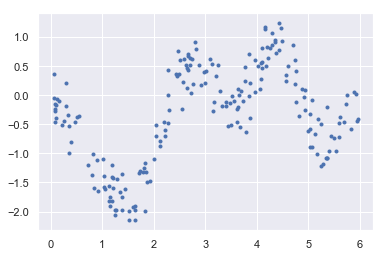

In [99]:
with open('train_inputs') as f:
    x_train = np.array(list(map(float, f))).reshape((-1, 1))
    
with open('train_outputs') as f:
    y_train = np.array(list(map(float, f)))

with open('test_inputs') as f:
    x_test = np.array(list(map(float, f))).reshape((-1, 1))

mux, stdx = x_train.mean(), x_train.std()
muy, stdy = y_train.mean(), y_train.std()

#x_train = (x_train - mux) / stdx
#x_test = (x_test - mux) / stdx
#y_train = (y_train - muy) / stdy

mask = np.squeeze((x_train < -0.25) | (x_train > 1))
#x_train, y_train = x_train[mask], y_train[mask]

plt.plot(x_train, y_train, '.')

# Squared exponential kernel

The kernel is compute as follows:

$$
k(\mathbf{x}_i,\mathbf{x}_j)=\sigma_f^2\cdot\exp\left(
-\frac{1}{2\ell^2}\lVert\mathbf{x}_i-\mathbf{x}_j\rVert^2
\right)
$$

And its derivatives w.r.t. its hyper-parameters are:

\begin{align*}
\frac{\partial k(\mathbf{x}_i,\mathbf{x}_j)}{\partial\sigma_f}
&=2\sigma_f\cdot\exp\left(
-\frac{1}{2\ell^2}\lVert\mathbf{x}_i-\mathbf{x}_j\rVert^2
\right) \\
\frac{\partial k(\mathbf{x}_i,\mathbf{x}_j)}{\partial\ell}
&=k(\mathbf{x}_i,\mathbf{x}_j)\cdot\left(
\lVert\mathbf{x}_i-\mathbf{x}_j\rVert^2+\frac{1}{\ell^3}
\right)
\end{align*}

The kernel matrix is defined as $\mathbf{K}_{i,j}=k(\mathbf{x}_i,\mathbf{x}_j)$, and the matrices $\partial K/\partial \sigma_f$ and $\partial K/\partial \ell$ are defined similarly.

In [4]:
class SquaredExponentialKernel:
    def __init__(self, sigma, len_scale):
        self.sigma = sigma
        self.len_scale = len_scale
    
    def get_params(self):
        return np.array([self.sigma, self.len_scale])
    
    def set_params(self, *params):
        self.sigma, self.len_scale = params
    
    def compute_pairwise(self, A, B):
        # compute the (NxM) kernel matrix K between points in A (NxD) and B (MxD)
        # and its derivative wrt the hyper-parameters
        # i.e. K[i,j] = k(A[i,:], B[j,:])

        N, M = len(A), len(B)
        grid_a, grid_b = np.meshgrid(range(len(A)), range(len(B)))
        dots = np.sum((A[grid_a] - B[grid_b])**2, axis=2).T
        return self._compute_kernel_and_derivatives(dots)
    
    def compute_aligned(self, A, B):
        # compute the (Nx1) kernel vector k between the points in A (NxD) and B (NxD)
        # and its derivative wrt the hyper-parameters
        # i.e. k[i] = k(A[i,:], B[i,:])
        assert A.shape == B.shape
        dots = np.sum((A - B)**2, axis=1)
        return self._compute_kernel_and_derivatives(dots)
    
    def _compute_kernel_and_derivatives(self, dots):
        # compute the kernel value and its derivatives using the matrix/vector of L2 norms
        ker_exp = np.exp(-dots / (2 * self.len_scale**2))
        ker = self.sigma**2 * ker_exp
        dker_dsigma = 2 * self.sigma * ker_exp
        dker_dlen = ker * (dots / self.len_scale**3)

        return ker, (dker_dsigma, dker_dlen)

# Exact Gaussian Process
We first implement the exact gaussian process, to make sure we are optimizing the hyper-parameters correctly.

The predictive posterior $p(\mathbf{y}^*\vert\mathbf{y},\mathbf{x}^*)$ is a Gaussian Process mean and covariance

$$
\mu_{\mathbf{x}^*\vert\mathbf{y}}=\mathbf{K}_{\mathbf{x}^*n}(\sigma^2\mathbf{I}+\mathbf{K}_{nn})^{-1}\mathbf{y}
$$

$$
\mathbf{K}_{\mathbf{x}^*\mathbf{x}^*\vert\mathbf{y}}=\mathbf{K}_{\mathbf{x}^*\mathbf{x}^*}-\mathbf{K}_{\mathbf{x}^*n}(\sigma^2\mathbf{I}+\mathbf{K}_{nn})^{-1}\mathbf{K}_{n\mathbf{x}^*}+\sigma^2\mathbf{I}
$$

The hyper-parameters ($\sigma$ and the kernel parameters) are optimized by maximizing the log marginal likelihood. Let $\mathbf{C}=\sigma^2\cdot\mathbf{I}_n+\mathbf{K}_{nn}$, then the log marginal likelihood is computed as follows:

$$
\log p(\mathbf{y})=\log\mathcal{N}(\mathbf{y}\vert\mathbf{0},\mathbf{C})=
-\frac{N}{2}\log(2\pi)
-\frac{1}{2}\log\vert\mathbf{C}\vert
-\frac{1}{2}\mathbf{y}^T\mathbf{C}^{-1}\mathbf{y}
$$

Whose derivative with respect to a certain hyper-parameter $\theta_i$ is:

$$
\frac{\partial\log p(\mathbf{y})}{\partial\theta_i}=
-\frac{1}{2}\text{Tr}\left(\mathbf{C}^{-1}\frac{\partial\mathbf{C}}{\partial\theta_i}\right)
+\frac{1}{2}\mathbf{y}^T\mathbf{C}^{-1}\frac{\partial\mathbf{C}}{\partial\theta_i}\mathbf{C}^{-1}\mathbf{y}
$$

The maximization is performed via gradient ascent with restarts, since the objective function is non-convex.

In [200]:
class GaussianProcess:
    def __init__(self, sigma, kernel):
        self.sigma = sigma
        self.kernel = kernel
    
    def get_params(self):
        kernel_params = self.kernel.get_params()
        return np.array([self.sigma] + list(kernel_params))
    
    def set_params(self, *params):
        self.sigma = params[0]
        self.kernel.set_params(*params[1:])
    
    def compute_log_marginal_likelihood(self, inputs, targets):
        N = len(inputs)

        ker, dker = self.kernel.compute_pairwise(inputs, inputs)
        cov = self.sigma**2 * np.eye(N) + ker
        dcov_dsigma = 2 * self.sigma * np.eye(N)
        cov_inv = np.linalg.inv(cov)
        sign, logdet = np.linalg.slogdet(cov)

        # compute the log marginal likelihood
        lml = -(
            sign * logdet
            + targets.T.dot(cov_inv).dot(targets)
            + N * np.log(2 * np.pi)
        ) / 2

        # compute the derivative of the log marginal likelihood wrt a certain parameter
        # given the derivative of the covariance matrix wrt that parameter
        # TODO how to parallelize?
        def compute_d_lml(dcov_dparam):
            return (
                - np.trace(dcov_dparam * cov_inv)  # FIXME element-wise product or matrix product??
                + targets.T.dot(cov_inv).dot(dcov_dparam).dot(cov_inv).dot(targets)
            ) / 2

        return lml, np.array([
            compute_d_lml(dcov)
            for dcov in (dcov_dsigma,) + dker
        ])
    
    def compute_posterior(self, inputs, targets, test_inputs):
        Kxn, _ = self.kernel.compute_pairwise(test_inputs, inputs)
        Kxx, _ = self.kernel.compute_pairwise(test_inputs, test_inputs)
        Knn, _ = self.kernel.compute_pairwise(inputs, inputs)
        
        kcov = Kxn.dot(np.linalg.inv(self.sigma**2 * np.eye(len(inputs)) + Knn))
        
        mean = kcov.dot(targets)
        cov = Kxx - kcov.dot(Kxn.T) + self.sigma**2 * np.eye(len(test_inputs))
        
        return mean, cov
    
    def sample_posterior(self, inputs, targets, test_inputs, noisy=False):
        mean, cov = self.compute_posterior(inputs, targets, test_inputs)
        if not noisy:
            cov -= self.sigma**2 * np.eye(len(test_inputs))
        return stats.multivariate_normal.rvs(mean, cov)

Follows an implementation of gradient ascent with momentum and gradient clipping:

In [85]:
class GradientDescentOptimizer:
    def __init__(self, momentum=0.9, base_lrate=1, clip_gradient=1,
                 min_improvement=1e-3, max_steps=1000, verbose=0,
                 raise_exceptions=False):
        self.momentum = momentum
        self.base_lrate = base_lrate
        self.clip_gradient = clip_gradient
        self.min_improvement = min_improvement
        self.max_steps = max_steps
        self.verbose = verbose
        self.raise_exceptions = raise_exceptions

    def log(self, level, *message):
        if level <= self.verbose:
            print(*message)
        
    def maximize(self, initial, f, *f_args):
        old_gradient = None
        old_value = -np.inf
        parameters = initial
        base_lrate = self.base_lrate
        best = old_value, parameters
        
        for i in range(self.max_steps):
            try:
                value, gradient = f(parameters, *f_args)
            except Exception as exc:
                if self.raise_exceptions:
                    raise
                else:
                    self.log(0, exc)
                    break

            # update best guess
            if value > best[0]:
                best = value, parameters

            # halve learning rate if function decreased
            if value < old_value:
                base_lrate *= 0.5

            # decay learning rate
            lrate = base_lrate / np.sqrt(i + 1)
                
            # clip gradient
            mag = np.sqrt(np.sum(gradient**2))
            if self.clip_gradient > 0 and mag > self.clip_gradient:
                gradient = gradient * self.clip_gradient / mag
                
            # apply momentum
            if old_gradient is not None:
                gradient = self.momentum * old_gradient + (1 - self.momentum) * gradient

            # update, log and check for stopping criterion
            parameters += lrate * gradient
            
            self.log(2, 'IT: %d\tLLI: %.3f\tIM: %.3e\tLR: %.3e\tMAG: %.3f - %s' % (
                i, value, old_value - value, lrate, mag, parameters
            ))

            if i > 10 and abs(value - old_value) < self.min_improvement:
                break

            old_value, old_gradient = value, gradient

        return best

    def maximize_with_restarts(self, num_restarts, sample_initial, f, *f_args):
        best = None
        for i in range(num_restarts):
            parameters = sample_initial()
            value, parameters = self.maximize(parameters, f, *f_args)
            if best is None or value > best[0]:
                best = value, parameters
            self.log(1, '--------------------- %d - Got: %.4f - Best: %.4f' % (i + 1, value, best[0]))
            self.log(1, '----', parameters)

        return best

We can now find good hyper-parameters for the exact GP posterior, using a gamma hyper-prior.

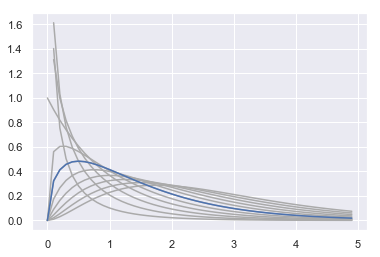

In [108]:
xx = np.arange(0, 5, 0.1)
for i in np.arange(0, 3, 0.25):
    plt.plot(xx, stats.gamma(i).pdf(xx), color='#aaaaaa')
plt.plot(xx, stats.gamma(1.5).pdf(xx))

In [109]:
gp = GaussianProcess(1, SquaredExponentialKernel(1, 1))
def target_f(parameters, inputs, targets):
    gp.set_params(*parameters)
    lml, lml_gradient = gp.compute_log_marginal_likelihood(inputs, targets)
    return lml, lml_gradient


exact_likelihood, exact_parameters = GradientDescentOptimizer(
    base_lrate=0.25,
    momentum=0.9,
    verbose=1,
    min_improvement=1e-6,
    raise_exceptions=True,
).maximize_with_restarts(
    50,
    lambda: stats.gamma(1.5).rvs(size=3),
    target_f, x_train, y_train
)

exact_likelihood, exact_parameters

--------------------- 1 - Got: -232.3576 - Best: -232.3576
---- [0.89006553 0.59231864 5.02547241]
--------------------- 2 - Got: -174.7145 - Best: -174.7145
---- [0.53391207 0.79019971 2.31109239]
--------------------- 3 - Got: -164.8377 - Best: -164.8377
---- [0.4603776  0.24942813 1.08198292]
--------------------- 4 - Got: -245.5421 - Best: -164.8377
---- [0.79029733 0.19237894 6.80318935]
--------------------- 5 - Got: -157.7455 - Best: -157.7455
---- [0.51535735 2.48523492 2.10552163]
--------------------- 6 - Got: -74.1186 - Best: -74.1186
---- [0.33731578 0.35740504 0.36739804]
--------------------- 7 - Got: -99.8697 - Best: -74.1186
---- [0.28454348 0.22978378 0.60000192]
--------------------- 8 - Got: -89.5237 - Best: -74.1186
---- [0.23742643 0.23507034 0.58410349]
--------------------- 9 - Got: -81.1869 - Best: -74.1186
---- [0.24148781 0.2448828  0.52648887]
--------------------- 10 - Got: -186.4878 - Best: -74.1186
---- [0.54150715 0.26958794 1.48498437]
------------------

(-57.19454641601703, array([0.2839712 , 0.62538888, 0.49088839]))

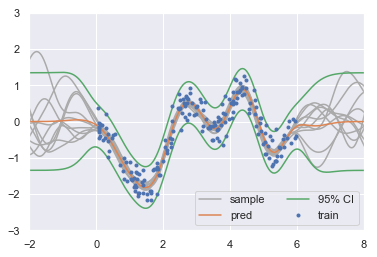

In [218]:
gp = GaussianProcess(1, SquaredExponentialKernel(1, 1))
gp.set_params(*exact_parameters)

exact_mean, cov = gp.compute_posterior(x_train, y_train, x_test)
exact_sigma = np.sqrt(np.diag(cov))

for i in range(10):
    pp = gp.sample_posterior(x_train, y_train, x_test, noisy=False)
    label = 'sample' if i == 0 else None
    plt.plot(x_test, pp, color='#aaaaaa', label=label)

plt.plot(x_test, exact_mean, label='pred', color='C1')
plt.plot(x_test, exact_mean + 1.96 * exact_sigma, color='C2', label='95% CI')
plt.plot(x_test, exact_mean - 1.96 * exact_sigma, color='C2')
plt.plot(x_train, y_train, '.', color='C0', label='train')
plt.ylim(-3, 3)
plt.xlim(-2, 8)
plt.legend(loc='lower right', ncol=2)
plt.show()

In [145]:
gp = GaussianProcess(1, SquaredExponentialKernel(1, 1))

values = []
for i in range(25000):
    params = np.random.random(size=2) * 10
    gp.set_params(0.3, *params)
    ll, _ = gp.compute_log_marginal_likelihood(x_train, y_train)
    values.append((params, ll))

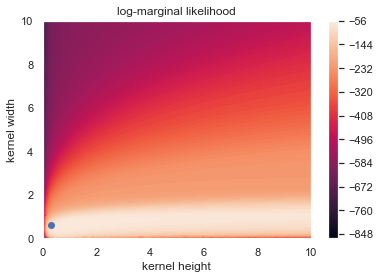

In [171]:
aa = np.array([(x, y, z) for (x, y), z in values])
plt.tricontourf(aa[:, 0], aa[:, 1], aa[:, 2], levels=100)
plt.plot(exact_parameters[0], exact_parameters[1], 'o')
plt.xlabel('kernel height')
plt.ylabel('kernel width')
plt.title('log-marginal likelihood')
plt.colorbar()

# Sparse GP

We start with a naive implementation. The problem is that we explicitly compute $Q_{nn}$, therefore the computational complexity of training does not improve by sparsity; we will deal with this issue later on.

The optimized lower bound of the approximate log marginal likelihood is (eq. 9):

$$
F_V=\log\mathcal{N}(\mathbf{y}\vert\mathbf{0},\sigma^2\mathbf{I}+\mathbf{Q}_{nn})-\frac{1}{2\sigma^2}\text{Tr}(\mathbf{\tilde{K}})
$$

Where

\begin{align*}
\mathbf{Q}_{nn}&=\mathbf{K}_{nm}\mathbf{K}_{mm}^{-1}\mathbf{K}_{mn} \\
\mathbf{\tilde{K}}&=\mathbf{K}_{nn}-\mathbf{Q}_{nn}
\end{align*}

We can use the formula presented earlier to maximize the lower bound with respect to the kernel hyper-parameters, where now $\mathbf{C}=\sigma^2\mathbf{I}+\mathbf{Q}_{nn}$. Therefore, we need to differentiate $\mathbf{C}$ (i.e. $\mathbf{Q}_{nn}$) with respect to $\theta_i$.

Some useful matrix calculus:

$$
\frac{\partial}{\partial x}\mathbf{A}\mathbf{B}
=\frac{\partial\mathbf{A}}{\partial x}\mathbf{B}
+\mathbf{A}\frac{\partial\mathbf{B}}{\partial x}
$$

$$
\frac{\partial}{\partial x}\mathbf{A}^{-1}=-\mathbf{A}^{-1}\frac{\partial\mathbf{A}}{\partial x}\mathbf{A}^{-1}
$$

Then we have:

\begin{align*}
\frac{\partial}{\partial\theta_i}\mathbf{Q}_{nn}
&=\frac{\partial}{\partial\theta_i}\mathbf{K}_{nm}\mathbf{K}_{mm}^{-1}\mathbf{K}_{mn}\\
&=\left(\frac{\partial}{\partial\theta_i}\mathbf{K}_{nm}\mathbf{K}_{mm}^{-1}\right)\mathbf{K}_{mn}
+\mathbf{K}_{nm}\mathbf{K}_{mm}^{-1}\frac{\partial\mathbf{K}_{mn}}{\partial\theta_i} \\
&=\frac{\partial{\mathbf{K}_{nm}}}{\partial\theta_i}\mathbf{K}_{mm}^{-1}\mathbf{K}_{mn}
+\mathbf{K}_{nm}\left(\frac{\partial}{\partial\theta_i}\mathbf{K}_{mm}^{-1}\right)\mathbf{K}_{mn}
+\mathbf{K}_{nm}\mathbf{K}_{mm}^{-1}\frac{\partial\mathbf{K}_{mn}}{\partial\theta_i} \\
&=\frac{\partial{\mathbf{K}_{nm}}}{\partial\theta_i}\mathbf{K}_{mm}^{-1}\mathbf{K}_{mn}
-\mathbf{K}_{nm}\mathbf{K}_{mm}^{-1}\frac{\partial\mathbf{K}_{mm}}{\partial\theta_i}\mathbf{K}_{mm}^{-1}\mathbf{K}_{mn}
+\mathbf{K}_{nm}\mathbf{K}_{mm}^{-1}\frac{\partial\mathbf{K}_{mn}}{\partial\theta_i}
\end{align*}

Where we applied the product rule twice, followed by the inversion rule.

We also need to differentiate the trace with respect to the hyper-parameters. Given that $\text{Tr}(\mathbf{K}_{nn}+\mathbf{Q}_{nn})=\text{Tr}(\mathbf{K}_{nn})+\text{Tr}(\mathbf{Q}_{nn})$, we can focus on $\text{Tr}(\mathbf{Q}_{nn})$; the elements on its diagonal are computed as follows:

\begin{align*}
\left(\mathbf{Q}_{nn}\right)_{i,i}&=\sum_{k=1}^n\left(
\left(\mathbf{K}_{mn}\right)_{k,i}\cdot\sum_{l=1}^m\left(\mathbf{K}_{nm}\right)_{i,l}\cdot\left(\mathbf{K}_{mm}^{-1}\right)_{l,k}
\right) \\
&=\sum_{k,l}\left(\mathbf{K}_{nm}\right)_{i,l}\cdot\left(\mathbf{K}_{nm}\right)_{i,k}\cdot\left(\mathbf{K}_{mm}^{-1}\right)_{l,k}
\end{align*}

Then, an equivalent formula for the trace is:

\begin{align*}
\text{Tr}\left(\mathbf{Q}_{nn}\right)&=
\sum_{i=1}^n\sum_{k,l}\left(\mathbf{K}_{nm}\right)_{i,l}\cdot\left(\mathbf{K}_{nm}\right)_{i,k}\cdot\left(\mathbf{K}_{mm}^{-1}\right)_{l,k} \\
&=\sum_{k,l}\left(
\left(\mathbf{K}_{mm}^{-1}\right)_{l,k}\cdot\sum_{i}\left(\mathbf{K}_{mn}\right)_{l,i}\cdot\left(\mathbf{K}_{nm}\right)_{i,k}
\right) \\
&=\sum_{k,l}\left(\mathbf{K}_{mm}^{-1}\right)_{l,k}\cdot\left(\mathbf{K}_{mn}\mathbf{K}_{nm}\right)_{l,k} \\
&=\lVert\mathbf{K}_{mm}^{-1}\circ\mathbf{K}_{mn}\mathbf{K}_{nm}\lVert
\end{align*}

Where $\circ$ is the Hadamard (element-wise) product, and $\lVert\cdot\lVert$ is the grand sum of the matrix entries. We can now differentiate the above expression:

\begin{align*}
\frac{\partial}{\partial\theta_i}\lVert\mathbf{K}_{mm}^{-1}\circ\mathbf{K}_{mn}\mathbf{K}_{nm}\lVert
&=\left\lVert
\frac{\partial\mathbf{K}_{mm}^{-1}}{\partial\theta_i}\circ\mathbf{K}_{mn}\mathbf{K}_{nm}
+\mathbf{K}_{mm}^{-1}\circ\frac{\partial}{\partial\theta_i}\left(\mathbf{K}_{mn}\mathbf{K}_{nm}\right)
\right\rVert\\
&=
\bigg\lVert
\frac{\mathbf{K}_{mm}^{-1}}{\partial\theta_i}\circ\mathbf{K}_{mn}\mathbf{K}_{nm}
+\mathbf{K}_{mm}^{-1}\circ\left(\frac{\partial\mathbf{K}_{mn}}{\partial\theta_i}\mathbf{K}_{nm}
+\mathbf{K}_{mn}\frac{\partial\mathbf{K}_{nm}}{\partial\theta_i}\right)
\bigg\rVert
\end{align*}

In [65]:
class SparseGP:
    def __init__(self, sigma, kernel):
        self.kernel = kernel
        self.sigma = sigma
    
    def get_params(self):
        kernel_params = self.kernel.get_params()
        return np.array([self.sigma] + list(kernel_params))
    
    def set_params(self, *params):
        self.sigma = params[0]
        self.kernel.set_params(*params[1:])
        
    def compute_log_marginal_likelihood(self, inducing, inputs, targets):
        N = len(inputs)

        # compute kernels
        Knm, dKnm = self.kernel.compute_pairwise(inputs, inducing)
        Kmm, dKmm = self.kernel.compute_pairwise(inducing, inducing)
        
        # add small jitter to diagonal to enhance stability
        Kmm += 1e-9 * np.eye(*Kmm.shape)
        Knm += 1e-9 * np.eye(*Knm.shape)
        Kmn = Knm.T
        
        # compute temporary values
        Kmm_inv = np.linalg.pinv(Kmm)
        Qnn = Knm.dot(Kmm_inv).dot(Kmn)
        Knn_diag, dKnn_diag = self.kernel.compute_aligned(inputs, inputs)
        cov = Qnn + self.sigma**2 * np.eye(N)
        cov_inv = np.linalg.inv(cov)
        trace = np.sum(Knn_diag) - np.trace(Qnn)
        regu = trace / (2 * self.sigma**2)
        
        # compute log marginal likelihood
        sign, logdet = np.linalg.slogdet(cov)
        lml = -(
            N * np.log(2 * np.pi)
            + sign * logdet
            + targets.T.dot(cov_inv).dot(targets)
        ) / 2 - regu

        # save diagnostics info
        self.diagnostics =  {
            'A': -N * np.log(2 * np.pi) / 2,
            'B': -sign * logdet / 2,
            'C': -targets.T.dot(cov_inv).dot(targets) / 2,
            'D': -regu,
            'lml': lml,
        }
        
        # compute gradient, first wrt sigma, then wrt kernel parameters
        dcov_dsigma = 2 * self.sigma * np.eye(N)
        dlml = [(
            - np.trace(cov_inv.dot(dcov_dsigma))
            + targets.T.dot(cov_inv).dot(dcov_dsigma).dot(cov_inv).dot(targets)
        ) / 2 + trace / (self.sigma**3)]
        
        for dKnn_dt, dKnm_dt, dKmm_dt in zip(dKnn_diag, dKnm, dKmm):
            dKmn_dt = dKnm_dt.T
            
            # derivative of Qnn
            dQnn_dt = (
                dKnm_dt.dot(Kmm_inv).dot(Kmn)
                - Knm.dot(Kmm_inv).dot(dKmm_dt).dot(Kmm_inv).dot(Kmn)
                + Knm.dot(Kmm_inv).dot(dKmn_dt)
            )
            
            # derivative of likelihood
            dlml_dt = (
                - np.trace(cov_inv.dot(dQnn_dt))
                + targets.T.dot(cov_inv).dot(dQnn_dt).dot(cov_inv).dot(targets)
            ) / 2
            
            # derivative of Tr(Qnn)
            dtrace_Qnn_dt = np.sum(-Kmm_inv.dot(dKmm_dt).dot(Kmm_inv) * Kmn.dot(Knm) + Kmm_inv * (
                dKmn_dt.dot(Knm) + Kmn.dot(dKnm_dt)
            ))
            
            # derivative of regularization term
            dcorr_dt = (dKnn_dt.sum() - dtrace_Qnn_dt) / (2 * self.sigma**2)
            
            dlml.append(dlml_dt - dcorr_dt)
        
        return lml, np.array(dlml)
        
    def compute_posterior(self, inducing_inputs, inputs, targets, test_inputs):
        Kmm, _ = self.kernel.compute_pairwise(inducing_inputs, inducing_inputs)
        Kmn, _ = self.kernel.compute_pairwise(inducing_inputs, inputs)
        Kxm, _ = self.kernel.compute_pairwise(test_inputs, inducing_inputs)
        Kxx, _ = self.kernel.compute_pairwise(test_inputs, test_inputs)
        
        # add small jitter to diagonal to enhance stability
        Kmm += 1e-9 * np.eye(*Kmm.shape)
        Kmn += 1e-9 * np.eye(*Kmn.shape)
        Kxm += 1e-9 * np.eye(*Kxm.shape)
        Kxx += 1e-9 * np.eye(*Kxx.shape)
        
        Kmm_inv = np.linalg.inv(Kmm)
        capital_sigma = np.linalg.inv(Kmm + self.sigma**-2 * Kmn.dot(Kmn.T))
        
        mu = self.sigma**-2 * Kmm.dot(capital_sigma).dot(Kmn).dot(targets)
        mean = Kxm.dot(Kmm_inv).dot(mu)
        cov = Kxx - Kxm.dot(Kmm_inv).dot(Kxm.T) + Kxm.dot(capital_sigma).dot(Kxm.T)
        
        return mean, cov + self.sigma**2 * np.eye(len(test_inputs))

We verify the analytical gradient computation by comparing it with the empirical gradient obtained through finite differencing

In [66]:
inducing, inputs, targets = x_train[20:25], x_train[:10], y_train[:10]

sgp = SparseGP(0.1, SquaredExponentialKernel(0.1, 0.1))
params = list(sgp.get_params())

lml, dlml_computed = sgp.compute_log_marginal_likelihood(inducing, inputs, targets)

eps = 1e-9
for i, dp in enumerate(dlml_computed):
    neg_params = params[:]
    neg_params[i] -= eps
    sgp.set_params(*neg_params)
    lml_neg, _ = sgp.compute_log_marginal_likelihood(inducing, inputs, targets)
    
    pos_params = params[:]
    pos_params[i] += eps
    sgp.set_params(*pos_params)
    lml_pos, _ = sgp.compute_log_marginal_likelihood(inducing, inputs, targets)
    
    diff = (lml_pos - lml_neg) / (2 * eps)
    print('Parameter %d - Analytic gradient: %.4f \t Finite Differences gradient: %.4f' % (
        i + 1, dlml_computed[i], diff
    ))
    
    assert np.allclose(dlml_computed[i], diff)

Parameter 1 - Analytic gradient: 6849.3086 	 Finite Differences gradient: 6849.3085
Parameter 2 - Analytic gradient: -78.3731 	 Finite Differences gradient: -78.3731
Parameter 3 - Analytic gradient: 33.7053 	 Finite Differences gradient: 33.7053


We can now train the sparse GP:

--- 1 ---------
Sample 141 has the largest likelihood: -5903.434756
Optimized hyper-parameters: [0.57876927 0.26519804 0.56922309] - Likelihood -192.881063


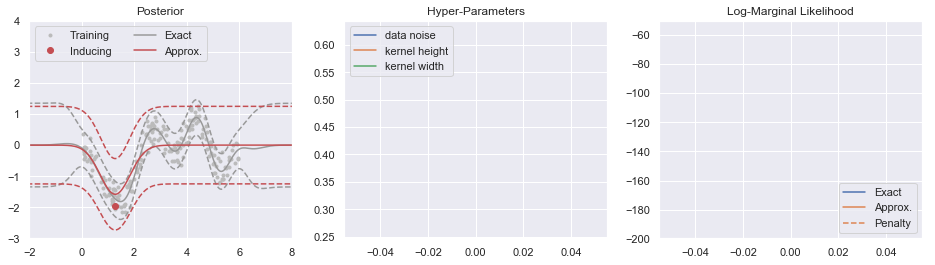

--- 2 ---------
Sample 169 has the largest likelihood: -181.280986
Optimized hyper-parameters: [0.53844796 0.27979822 0.5441623 ] - Likelihood -179.887968


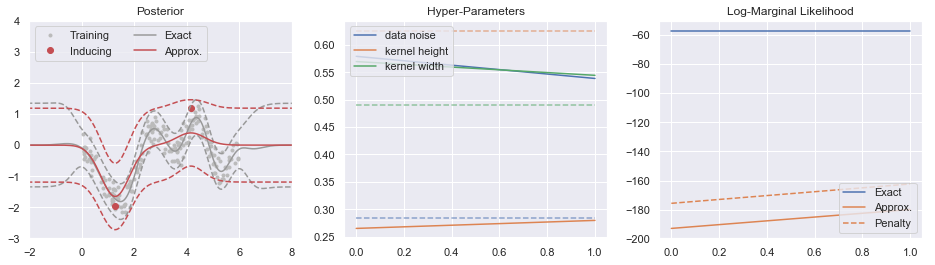

--- 3 ---------
Sample 189 has the largest likelihood: -159.726370
Optimized hyper-parameters: [0.46947788 0.28926909 0.54098913] - Likelihood -156.152951


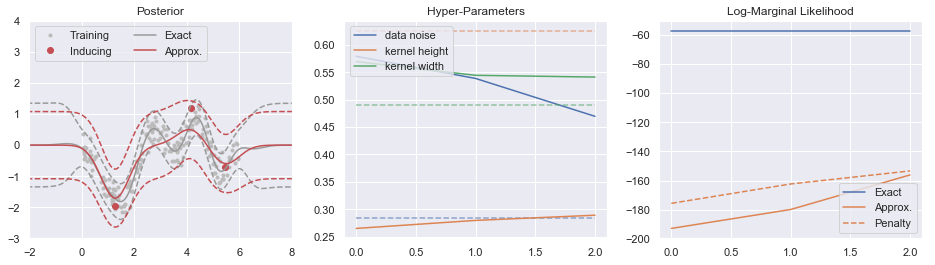

--- 4 ---------
Sample 172 has the largest likelihood: -145.810305
Optimized hyper-parameters: [0.4445628  0.31571696 0.55821112] - Likelihood -144.370296


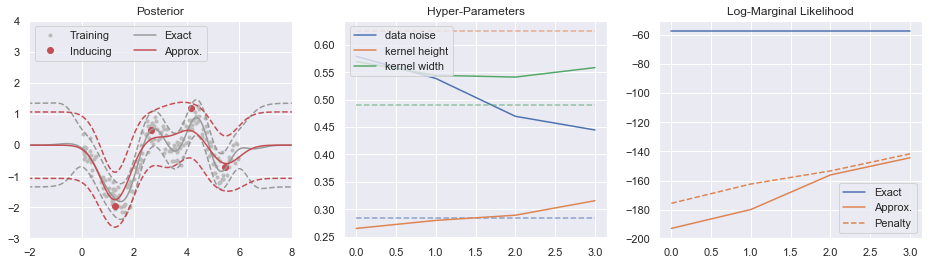

--- 5 ---------
Sample 63 has the largest likelihood: -126.689714
Optimized hyper-parameters: [0.39311223 0.33777626 0.5684584 ] - Likelihood -123.243238


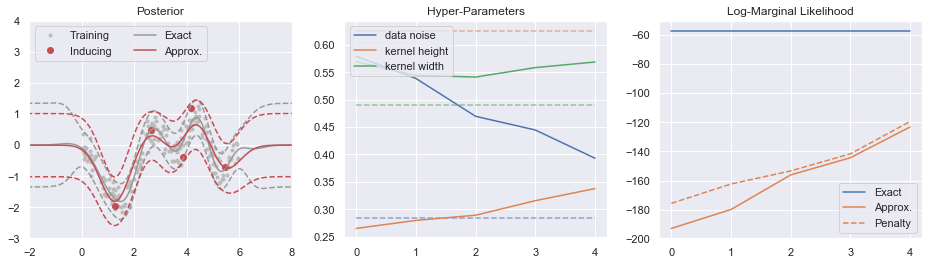

--- 6 ---------
Sample 153 has the largest likelihood: -105.378874
Optimized hyper-parameters: [0.34733499 0.34057662 0.53465647] - Likelihood -102.001873


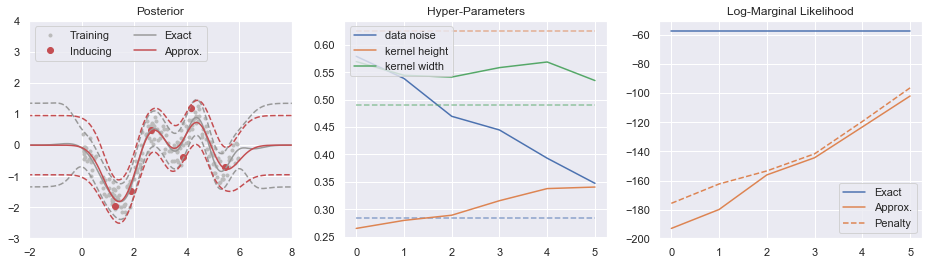

--- 7 ---------
Sample 61 has the largest likelihood: -91.035534
Optimized hyper-parameters: [0.31994741 0.38621794 0.59954435] - Likelihood -87.633151


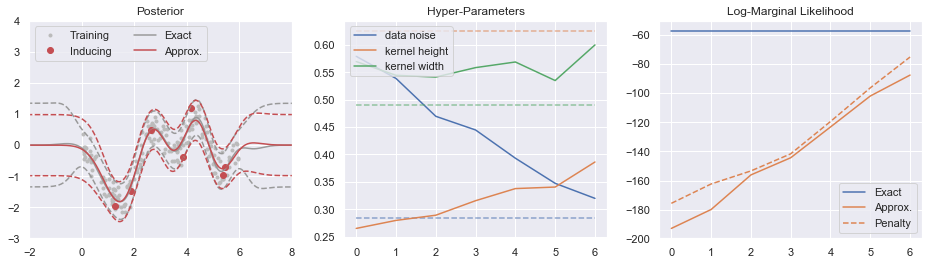

--- 8 ---------
Sample 151 has the largest likelihood: -75.137608
Optimized hyper-parameters: [0.29708927 0.79165515 0.74590483] - Likelihood -66.922448


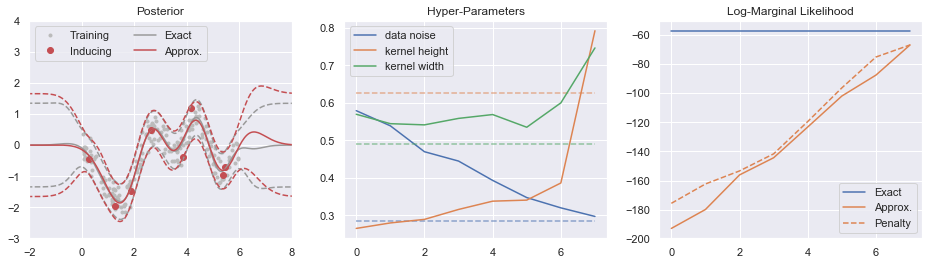

--- 9 ---------
Sample 102 has the largest likelihood: -63.741456
Optimized hyper-parameters: [0.29191966 0.79068094 0.71089884] - Likelihood -63.086284


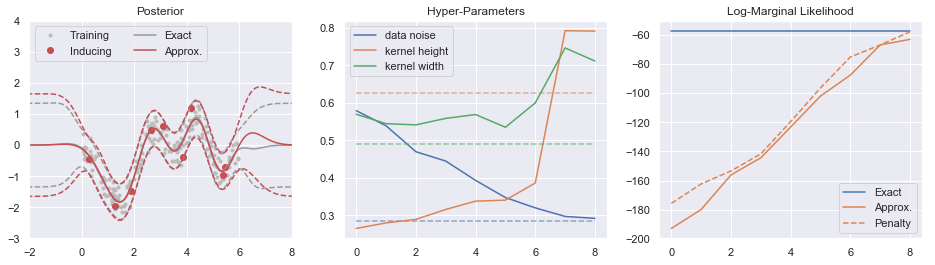

--- 10 ---------
Sample 157 has the largest likelihood: -60.667701
Optimized hyper-parameters: [0.28845575 0.89000074 0.71005677] - Likelihood -60.327155


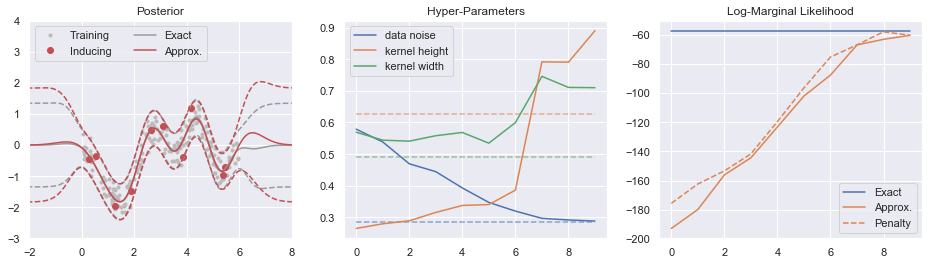

--- 11 ---------
Sample 17 has the largest likelihood: -58.236881
Optimized hyper-parameters: [0.28524773 0.92418895 0.6866485 ] - Likelihood -57.885969


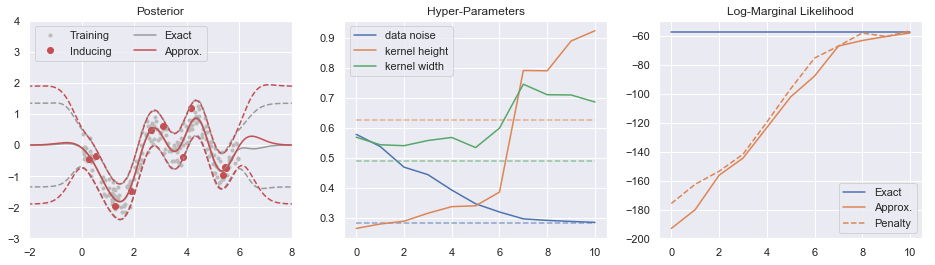

--- 12 ---------
Sample 112 has the largest likelihood: -57.154041
Optimized hyper-parameters: [0.28394541 0.91202437 0.66381422] - Likelihood -57.037578


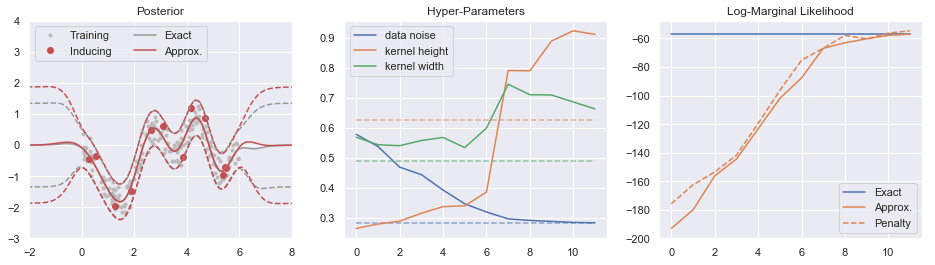

--- 13 ---------
Sample 26 has the largest likelihood: -56.580507
Optimized hyper-parameters: [0.28322432 0.89886813 0.64582462] - Likelihood -56.527167


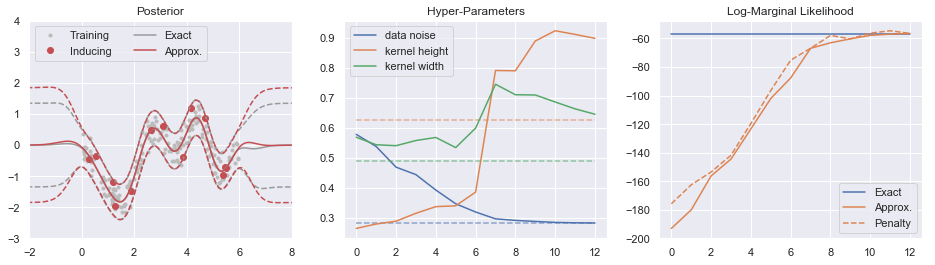

--- 14 ---------
Sample 121 has the largest likelihood: -56.319111
Optimized hyper-parameters: [0.28287303 0.90718066 0.63797929] - Likelihood -56.300767


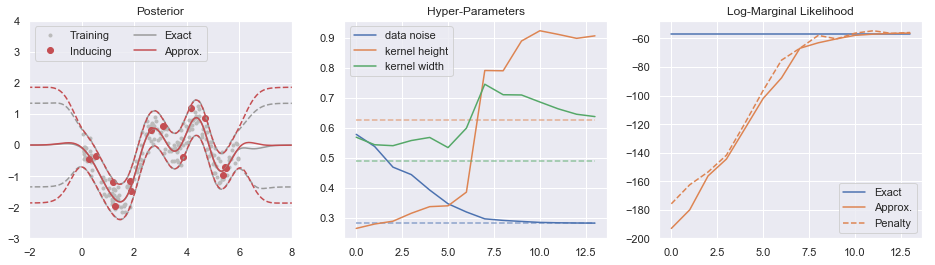

--- 15 ---------
Sample 85 has the largest likelihood: -56.122549
Optimized hyper-parameters: [0.28255922 0.88191549 0.62584249] - Likelihood -56.113995


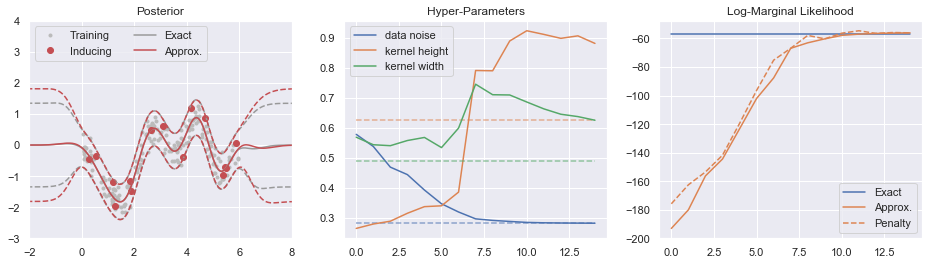

--- 16 ---------
Sample 152 has the largest likelihood: -55.977542
Optimized hyper-parameters: [0.28234214 0.87037764 0.61752653] - Likelihood -55.974845


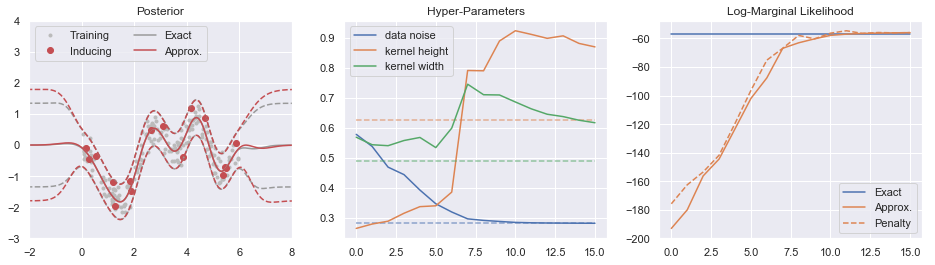

--- 17 ---------
Sample 73 has the largest likelihood: -55.913462
Optimized hyper-parameters: [0.28223102 0.88074057 0.61392587] - Likelihood -55.907753


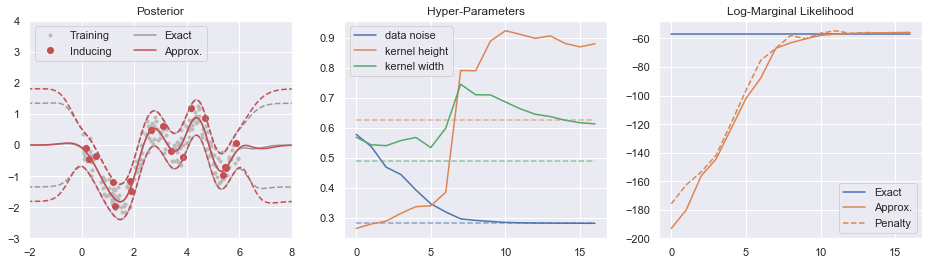

--- 18 ---------
Sample 155 has the largest likelihood: -55.903955
Optimized hyper-parameters: [0.28222916 0.89805113 0.61548922] - Likelihood -55.907705


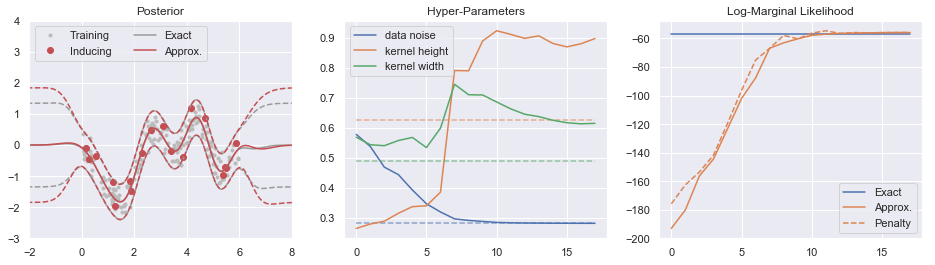

--- 19 ---------
Sample 44 has the largest likelihood: -55.905952
Optimized hyper-parameters: [0.28222112 0.88895537 0.61520693] - Likelihood -55.903327


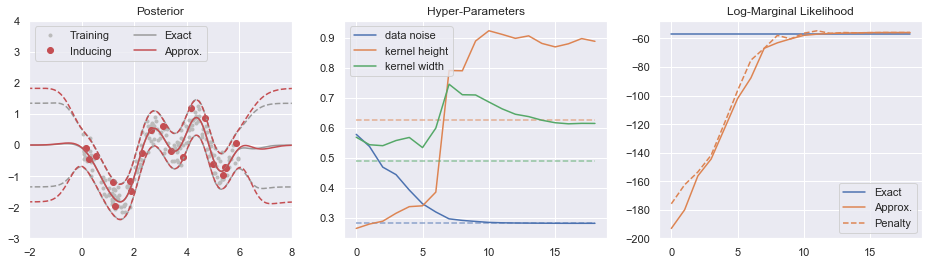

--- 20 ---------
Sample 193 has the largest likelihood: -55.901994
Optimized hyper-parameters: [0.28230835 0.87565443 0.61201195] - Likelihood -55.900889


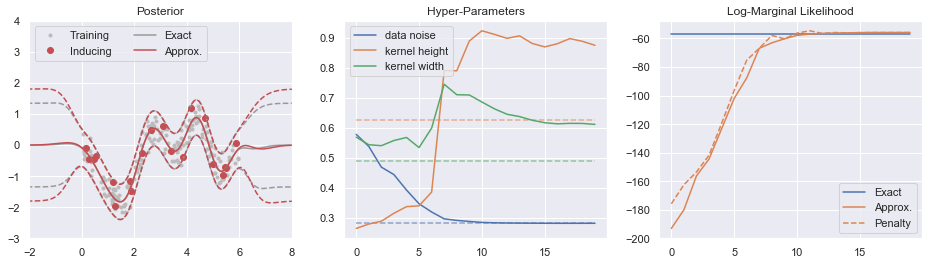

In [120]:
num_training_inputs = 200
num_pseudo_inputs = 20

idx = list(range(x_train.shape[0]))
np.random.shuffle(idx)
training_idx = idx[:num_training_inputs]
remaining_set = set(idx[:num_training_inputs])
inducing_idx = []

sgp = SparseGP(0.1, SquaredExponentialKernel(0.1, 0.1))
wrong_parameters = None
param_hist, lml_hist = [], []

for i in range(num_pseudo_inputs):
    print('--- %d ---------' % (i + 1))
    
    best = None
    for m in remaining_set:
        new_inducing_idx = inducing_idx + [m]
        bb, _ = sgp.compute_log_marginal_likelihood(
            x_train[new_inducing_idx],
            x_train[training_idx],
            y_train[training_idx],
        )

        if best is None or bb > best[1]:
            best = m, bb
    
    print('Sample %d has the largest likelihood: %f' % best)
    # remove sample from remaining and add it to inducing
    inducing_idx = inducing_idx + [best[0]]
    remaining_set.remove(best[0])

    def target_f(parameters, inducing, inputs, targets):
        sgp.set_params(*parameters)
        v, g = sgp.compute_log_marginal_likelihood(inducing, inputs, targets)
        if v > 0:
            global wrong_parameters
            wrong_parameters = parameters
            print(wrong_parameters)
            print(sgp.diagnostics)
            assert False, wrong_parameters
        return v, g

    likelihood, parameters = GradientDescentOptimizer(
        base_lrate=0.25,
        momentum=0.9,
        verbose=0,
        min_improvement=1e-4,
        raise_exceptions=True,
    ).maximize_with_restarts(
        25,
        lambda: stats.gamma(1.5).rvs(size=3),
        target_f, x_train[inducing_idx], x_train[training_idx], y_train[training_idx],
    )
    
    print('Optimized hyper-parameters: %s - Likelihood %f' % (parameters, likelihood))
    sgp.set_params(*parameters)
    mean, cov = sgp.compute_posterior(x_train[inducing_idx], x_train[training_idx], y_train[training_idx], x_test)
    
    param_hist.append(parameters)
    lml_hist.append((likelihood, likelihood - sgp.diagnostics['D']))
    
    # plot progress
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    sigma = np.sqrt(np.diag(cov))
    plt.plot(x_train[training_idx], y_train[training_idx], '.', color='#bbbbbb', label='Training')
    plt.plot(x_train[inducing_idx], y_train[inducing_idx], 'ro', label='Inducing')
    plt.plot(x_test, exact_mean, color='#999999', label='Exact')
    plt.plot(x_test, exact_mean + 1.96 * exact_sigma, '--', color='#999999')
    plt.plot(x_test, exact_mean - 1.96 * exact_sigma, '--', color='#999999')
    plt.plot(x_test, mean, color='C3', label='Approx.')
    plt.plot(x_test, mean + 1.96 * sigma, '--', color='C3')
    plt.plot(x_test, mean - 1.96 * sigma, '--', color='C3')
    plt.ylim(-3, 4)
    plt.xlim(-2, 8)
    plt.legend(loc='upper left', ncol=2)
    plt.title('Posterior')
    
    plt.subplot(1, 3, 2)
    labels, colors = ['data noise', 'kernel height', 'kernel width'], ['C0', 'C1', 'C2']
    for ep, ph, lbl, col in zip(exact_parameters, np.array(param_hist).T, labels, colors):
        plt.plot(ph, label=lbl, color=col)
        plt.plot([0, i], [ep, ep], '--', alpha=0.6, color=col)
    plt.legend(loc='upper left')
    plt.title('Hyper-Parameters')
    
    plt.subplot(1, 3, 3)
    plt.plot([0, i], [exact_likelihood, exact_likelihood], label='Exact')
    for lh, lbl, style in zip(np.array(lml_hist).T, ['Approx.', 'Penalty'], ['-', '--']):
        plt.plot(range(i + 1), lh, style, label=lbl, color='C1')
    plt.legend(loc='lower right')
    plt.title('Log-Marginal Likelihood')
    plt.show()

# Memory-efficient Sparse GP

As mentioned earlier, the naive implementation explicitly computes $\mathbf{Q}_{nn}$, making the memory requirements $O(N^2)$, at least for training; therefore, our goal is to perform all the computations without requiring $\mathbf{Q}_{nn}$. As a reminder, the lower bound is maximized by

$$
F_V=-\frac{N}{2}\log{2\pi}
-\frac{1}{2}\log\vert
\underbrace{\sigma^2\mathbf{I}+\mathbf{Q}_{nn}\vert}_{A}
-\frac{1}{2}
\underbrace{\mathbf{y}^T\left(\sigma^2\mathbf{I}+\mathbf{Q}_{nn}\right)^{-1}\mathbf{y}}_{B}
-\frac{1}{2\sigma^2}\underbrace{\text{Tr}(\mathbf{K}_{nn}-\mathbf{Q}_{nn})}_{C}
$$

An equivalent expression for $C$ that does not require $\mathbf{Q}_{nn}$ was presented earlier. We can apply the matrix determinant lemma to $A$:

$$
A=\text{det}\left(\sigma^2\mathbf{I}+\mathbf{K}_{nm}\mathbf{K}_{mm}^{-1}\mathbf{K}_{mn}\right)
=\sigma^{2N}\text{det}\left(\mathbf{K}_{mm}+\sigma^{-2}\mathbf{K}_{mn}\mathbf{K}_{nm}\right)
\text{det}\left(\mathbf{K}_{mm}^{-1}\right)
$$


We can then use the Woodbury identity to show that:

$$
\left(\sigma^2\mathbf{I}+\mathbf{K}_{nm}\mathbf{K}_{mm}^{-1}\mathbf{K}_{mn}\right)^{-1}
=\sigma^{-2}\mathbf{I}-\sigma^{-4}\mathbf{K}_{nm}\left(
\mathbf{K}_{mm}+\sigma^{-2}\mathbf{K}_{mn}\mathbf{K}_{nm}
\right)^{-1}\mathbf{K}_{mn}
$$

And by distributing the product with $\mathbf{y}$ we get

$$
B=\sigma^{-2}\mathbf{y}^T\mathbf{y}-\sigma^{-4}\mathbf{y}^T\mathbf{K}_{nm}\left(
\mathbf{K}_{mm}+\sigma^{-2}\mathbf{K}_{mn}\mathbf{K}_{nm}
\right)^{-1}\mathbf{K}_{mn}\mathbf{y}
$$

As a bonus, we implement this in tensorflow.

In [542]:
class SparseGpTf:
    def __init__(self, kernel_builder, session=None):
        self.kernel_builder = kernel_builder
        self.session = session
    
    def get_session(self):
        return self.session or tf.get_default_session()
    
    def get_params(self):
        sigma, kernel_params = self.get_session().run([self.sigma_in, self.kernel_params_in])
        return np.concatenate([[sigma], kernel_params])
    
    def set_params(self, params):
        self.get_session().run([
            self.sigma_in.assign(params[0]),
            self.kernel_params_in.assign(params[1:])
        ])
        
    def maximize_log_marginal_likelihood(
        self, inducing, inputs, targets, initial_params,
        base_lrate=0.01, momentum=0.9, max_iter=25000,
        min_improvement=1e-4):
        
        self.validate_and_assign_inputs(inducing, inputs, targets)
        self.set_params(initial_params)
        self.get_session().run([
            self.base_lrate.assign(base_lrate),
            self.momentum.assign(momentum),
        ])
        
        assert np.isfinite(self.compute_lml(inducing, inputs, targets)), initial_params
        
        last_lml, best = None, None
        for i in range(max_iter):
            lml, _ = self.get_session().run([self.lml_op, self.maximize_lml_op])
            print(lml, self.get_params())
            assert lml < 0
            if last_lml and abs(last_lml - lml) < min_improvement:
                break
                
            if not best or lml > best[0]:
                best = lml, self.get_params()
                
            last_lml = lml

        return best
    
    def maximize_lml_with_restarts(self, inducing, inputs, targets, num_restarts,
                                   sample_initial, **optimizer_kwargs):
        best = None
        for i in range(num_restarts):
            lml, params = self.maximize_log_marginal_likelihood(
                inducing, inputs, targets, sample_initial(), **optimizer_kwargs
            )
            
            print(i, lml, best)
            if not best or lml > best[0]:
                best = lml, params
        
        return best
    
    def compute_lml(self, inducing, inputs, targets):
        self.validate_and_assign_inputs(inducing, inputs, targets)
        lml, *xx = self.get_session().run([
            self.b_acc, self.lml_op, self.log_A, self.B, self.C
        ])
        #print(lml, xx)
        return lml

    def validate_and_assign_inputs(self, inducing, inputs, targets):
        assert len(inducing.shape) == 2, inducing.shape
        assert len(inputs.shape) == 2, inputs.shape
        assert len(targets.shape) == 1, targets.shape
        assert inducing.shape[1] == inputs.shape[1], (inputs.shape, inducing.shape)
        assert inputs.shape[0] == targets.shape[0], (inputs.shape, targets.shape)
        
        self.get_session().run([
            tf.assign(self.inputs, inputs, validate_shape=False),
            tf.assign(self.inducing, inducing, validate_shape=False),
            tf.assign(self.targets, targets.reshape(-1, 1), validate_shape=False)
        ])
    
    def build(self):
        # create input nodes
        self.inputs = tf.Variable([[0.1, 0.1], [0.1, 0.1]], validate_shape=False)
        self.inducing = tf.Variable([[0.1, 0.1], [0.1, 0.1]], validate_shape=False)
        self.targets = tf.Variable([[0.1, 0.1]], validate_shape=False)
        self.sigma_in = tf.Variable(0.1)
        self.kernel_params_in = tf.Variable([0.1] * self.kernel_builder.get_param_size())
        
        # compute kernels
        self.kernel_builder.build(self.inducing, self.inducing, self.kernel_params_in)
        Kmm = self.kernel_builder.get_pairwise_op()
        Kmm_inv = tf.linalg.inv(Kmm + 1e-9 * tf.eye(tf.shape(Kmm)[0]))
        
        self.kernel_builder.build(self.inducing, self.inputs, self.kernel_params_in)
        Kmn = self.kernel_builder.get_pairwise_op()
        Knm = tf.transpose(Kmn)
        
        self.kernel_builder.build(self.inputs, self.inputs, self.kernel_params_in)
        Knn_diag = self.kernel_builder.get_aligned_op()
        
        N = tf.cast(tf.shape(self.inputs)[0], tf.float32)
        Qnn_alt = 1e-9 * tf.eye(tf.shape(Kmm)[0]) + Kmm + tf.matmul(Kmn, Knm) / self.sigma_in**2
        
        # compute A
        qnn_logdet_sign, qnn_logdet = tf.linalg.slogdet(Qnn_alt)
        self.qnn_logdet = qnn_logdet_sign * qnn_logdet
        kmm_inv_logdet_sign, kmm_inv_logdet = tf.linalg.slogdet(Kmm_inv)
        self.kmm_inv_logdet = kmm_inv_logdet_sign * kmm_inv_logdet
        self.log_A = (- 2 * N * tf.log(self.sigma_in) - self.qnn_logdet - self.kmm_inv_logdet) / 2
        
        # compute B
        b_acc = tf.matmul(tf.transpose(self.targets), Knm)
        self.b_acc = Qnn_inv = tf.linalg.inv(Qnn_alt)  # FIXME matrix inversion fails
        
        #Qnn_L = tf.linalg.cholesky(Qnn_alt)
        #Qnn_L_inv = tf.linalg.inv(Qnn_L)
        #self.b_acc = Qnn_inv = tf.matmul(tf.transpose(Qnn_L_inv), Qnn_L_inv)
        
        b_acc = tf.matmul(b_acc, Qnn_inv)
        b_acc = tf.matmul(b_acc, Kmn)
        b_acc = tf.matmul(b_acc, self.targets)
        self.B = tf.reshape((
            - tf.reduce_sum(self.targets**2) / self.sigma_in**2 
            + b_acc / self.sigma_in**4
        ) / 2, shape=())
        
        # compute C
        self.C = tf.reshape((
            -tf.reduce_sum(Knn_diag) + tf.reduce_sum(
                tf.multiply(Kmm_inv, tf.matmul(Kmn, Knm))
            )) / (2 * self.sigma_in**2),
            shape=()
        )
        
        # compute log-marginal likelihood
        self.lml_op = -N * np.log(2 * np.pi) / 2 + self.log_A + self.B + self.C
        
        # create optimizer
        self.momentum = tf.Variable(0.9)
        self.opt_iter = tf.Variable(0)
        self.base_lrate = tf.Variable(0.01)
        self.lrate = self.base_lrate / tf.sqrt(tf.cast(self.opt_iter + 1, tf.float32))
        
        self.optimizer = tf.train.MomentumOptimizer(learning_rate=self.lrate, momentum=self.momentum)
        gradients, variables = zip(*self.optimizer.compute_gradients(-self.lml_op, var_list=[
            self.sigma_in, self.kernel_params_in
        ]))
        
        gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
        self.maximize_lml_op = self.optimizer.apply_gradients(
            zip(gradients, variables), global_step=self.opt_iter
        )


with tf.Session() as sess:
    sgptf = SparseGpTf(SquaredExponentialKernelTfBuilder())
    sgptf.build()
    sess.run(tf.global_variables_initializer())
    
    sgptf.set_params(parameters)
    b_acc = sgptf.compute_lml(x_train[inducing_idx], x_train[training_idx], y_train[training_idx])

    '''
    lml, params = sgptf.maximize_lml_with_restarts(
        x_train[inducing_idx], x_train[training_idx], y_train[training_idx],
        num_restarts=25, sample_initial=lambda: stats.gamma(1.5).rvs(size=3)
    )
    
    print(lml, params)
    '''

In [543]:
qnn_inv = np.linalg.inv(Kmm + Kmn.dot(Knm) / sigma**2)
np.allclose(qnn_inv, b_acc)

False

In [512]:
Kmm, _ = sgp.kernel.compute_pairwise(x_train[inducing_idx], x_train[inducing_idx])
Knm, _ = sgp.kernel.compute_pairwise(x_train[training_idx], x_train[inducing_idx])
Kmn = Knm.T
sigma = parameters[0]
targets = y_train[training_idx].reshape(-1, 1)

(
    -targets.T.dot(targets) / sigma**2
    + targets.T.dot(Knm).dot(np.linalg.inv(Kmm + Kmn.dot(Knm) / sigma**2)).dot(Kmn).dot(targets) / sigma**4
) / 2

array([[-99.9495708]])

In [491]:
'''
# save diagnostics info
self.diagnostics =  {
    'A': -N * np.log(2 * np.pi) / 2,
    'B': -sign * logdet / 2,
    'C': -targets.T.dot(cov_inv).dot(targets) / 2,
    'D': -regu,
    'lml': lml,
}
'''

sgp.compute_log_marginal_likelihood(
    x_train[inducing_idx], x_train[training_idx], y_train[training_idx]
)
print(sgp.diagnostics)

{'A': -183.78770664093454, 'B': 227.83709902137417, 'C': -99.94978339093754, 'D': -0.0004520516899471938, 'lml': -55.90084306218786}


In [508]:
import tensorflow as tf


class SquaredExponentialKernelTfBuilder:
    def build(self, A, B, params):
        sigma, len_scale = params[0], params[1]
        
        count_A, count_B = tf.shape(A)[0], tf.shape(B)[0]
        grid_a, grid_b = tf.meshgrid(tf.range(count_A), tf.range(count_B))
        
        ga = tf.gather(A, tf.reshape(tf.transpose(grid_a), (-1,)))
        gb = tf.gather(B, tf.reshape(tf.transpose(grid_b), (-1,)))
        
        pairwise_dots = tf.math.reduce_sum((ga - gb)**2, axis=1)
        pairwise_kernel = sigma**2 * tf.exp(-pairwise_dots / (2 * len_scale**2))
        self.pairwise_kernel = tf.reshape(pairwise_kernel, (count_A, count_B))
        
        aligned_dots = tf.math.reduce_sum((A - B)**2, axis=1)
        self.aligned_kernel = sigma**2 * tf.exp(-aligned_dots / (2 * len_scale**2))
    
    def get_param_size(self):
        return 2
    
    def get_pairwise_op(self):
        return self.pairwise_kernel
    
    def get_aligned_op(self):
        return self.aligned_kernel


class SquaredExponentialKernelTf:
    def __init__(self, sigma, len_scale, session):
        self.sigma, self.len_scale, self.session = sigma, len_scale, session
        
        self.A = tf.placeholder(tf.float32, shape=(None, None))
        self.B = tf.placeholder(tf.float32, shape=(None, None))
        self.params = tf.placeholder(tf.float32, shape=(2,))
        
        builder = SquaredExponentialKernelTfBuilder()
        builder.build(self.A, self.B, self.params)
        self.pairwise_op = builder.get_pairwise_op()
        self.aligned_op = builder.get_aligned_op()
    
    def get_params(self):
        return np.array([self.sigma, self.len_scale])
    
    def set_params(self, *params):
        self.sigma, self.len_scale = params

    def get_session(self):
        return self.session or tf.get_default_session()
        
    def compute_aligned(self, A, B):
        return self.get_session().run(self.aligned_op, feed_dict={
            self.A: A, self.B: B, self.params: self.get_params()
        })
    
    def compute_pairwise(self, A, B):
        return self.get_session().run(self.pairwise_op, feed_dict={
            self.A: A, self.B: B, self.params: self.get_params()
        })
        

# make sure implementation is correct
with tf.Session() as sess:
    params = [0.25, 0.11]
    
    tfker = SquaredExponentialKernelTf(0.1, 0.1, sess)
    tfker.set_params(*params)
    
    npker = SquaredExponentialKernel(0.1, 0.1)
    npker.set_params(*param)    
    
    tfkkp = tfker.compute_pairwise(x_train, x_test)
    npkkp, _ = npker.compute_pairwise(x_train, x_test)
    
    assert np.allclose(tfkkp, npkkp)
    
    tfkka = tfker.compute_aligned(x_train, x_train)
    npkka, _ = npker.compute_aligned(x_train, x_train)
    
    assert np.allclose(tfkka, npkka)

print('test passes')

test passes
